In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data

In [76]:
df_city_time_series = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/zillow-housing-price-20220213T072633Z-001/zillow-housing-price/data/City_time_series.csv',parse_dates=['Date'])
# drop null values in ZHVIPerSqft_AllHomes because we are interested in this column
df_city_time_series = df_city_time_series.dropna(subset=['ZHVIPerSqft_AllHomes'])
df_city_time_series.head()

Date            RegionName  InventorySeasonallyAdjusted_AllHomes  \
1 1996-04-30     aberdeenbinghamid                                   NaN   
2 1996-04-30     aberdeenharfordmd                                   NaN   
5 1996-04-30       abernathyhaletx                                   NaN   
7 1996-04-30     abingdonharfordmd                                   NaN   
9 1996-04-30  abingdonwashingtonva                                   NaN   

   InventoryRaw_AllHomes  MedianListingPricePerSqft_1Bedroom  \
1                    NaN                                 NaN   
2                    NaN                                 NaN   
5                    NaN                                 NaN   
7                    NaN                                 NaN   
9                    NaN                                 NaN   

   MedianListingPricePerSqft_2Bedroom  MedianListingPricePerSqft_3Bedroom  \
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
5                                 NaN                                 NaN   
7                                 NaN                                 NaN   
9                                 NaN                                 NaN   

   MedianListingPricePerSqft_4Bedroom  \
1                                 NaN   
2                                 NaN   
5                                 NaN   
7                                 NaN   
9                                 NaN   

   MedianListingPricePerSqft_5BedroomOrMore  \
1                                       NaN   
2                                       NaN   
5                                       NaN   
7                                       NaN   
9                                       NaN   

   MedianListingPricePerSqft_AllHomes  MedianListingPricePerSqft_CondoCoop  \
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
5                                 NaN                                  NaN   
7                                 NaN                                  NaN   
9                                 NaN                                  NaN   

   MedianListingPricePerSqft_DuplexTriplex  \
1                                      NaN   
2                                      NaN   
5                                      NaN   
7                                      NaN   
9                                      NaN   

   MedianListingPricePerSqft_SingleFamilyResidence  \
1                                              NaN   
2                                              NaN   
5                                              NaN   
7                                              NaN   
9                                              NaN   

   MedianListingPrice_1Bedroom  MedianListingPrice_2Bedroom  \
1                          NaN                          NaN   
2                          NaN                          NaN   
5                          NaN                          NaN   
7                          NaN                          NaN   
9                          NaN                          NaN   

   MedianListingPrice_3Bedroom  MedianListingPrice_4Bedroom  \
1                          NaN                          NaN   
2                          NaN                          NaN   
5                          NaN                          NaN   
7                          NaN                          NaN   
9                          NaN                          NaN   

   MedianListingPrice_5BedroomOrMore  MedianListingPrice_AllHomes  \
1                                NaN                          NaN   
2                                NaN                          NaN   
5                                NaN                          NaN   
7                                NaN                          NaN   

In [77]:
# the ZHVIPerSqft_AllHomes column has many value in same date but for different location. 
# For this notebook we are not interested in location. We mean all the value in same date
df_zhvi_sqft_all = df_city_time_series.set_index('Date') \
                    .groupby(pd.Grouper(freq='d')).mean().dropna(how='all') \
                    .ZHVIPerSqft_AllHomes
pd.set_option('display.max_rows', 10)
df_zhvi_sqft_all


Date
1996-04-30     72.056369
1996-05-31     72.021660
1996-06-30     71.979891
1996-07-31     71.976152
1996-08-31     71.964629
                 ...    
2017-08-31    144.095938
2017-09-30    144.777011
2017-10-31    145.517059
2017-11-30    146.236881
2017-12-31    146.824695
Name: ZHVIPerSqft_AllHomes, Length: 261, dtype: float64

# Pre-process the data
- pre-process data for feeding into LSTM
- transform data to stationary
- transform data to supervised learning
- split data into train and test
- scale data to (-1, 1)

In [78]:
# create a differenced series
# this is to make time series stationary
# why stationarity? => https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# frame a sequence as a supervised learning problem
# this methods will create a column and column value will be 1 shift from the data. 
# it will make our data to supervised so that we can feed into network
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [79]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value] # push_back
    array = np.array(new_row)
    array = array.reshape(1, len(array)) # convert to 2d
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Define model
- Use LSTM network
- Set hyper-parameters: layer depth, loss function, optimizer and etc.
- Be careful with input dimension

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [81]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
# N: input size( instance 개수) M : feature 개수 NxM -> Mx1 = Nx1
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

# Train the model



### Preprocess the data

In [82]:
series = df_zhvi_sqft_all
raw_values = series.values
# 1. transform data to be stationary
diff_values = difference(raw_values,1)
print(diff_values)

# 2. transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print(supervised_values)

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.80)
train = supervised_values[0:train_size]
test = supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

0     -0.034709
1     -0.041769
2     -0.003739
3     -0.011523
4      0.022334
         ...   
255    0.533794
256    0.681072
257    0.740049
258    0.719821
259    0.587815
Length: 260, dtype: float64
[[ 0.00000000e+00 -3.47086881e-02]
 [-3.47086881e-02 -4.17689782e-02]
 [-4.17689782e-02 -3.73861424e-03]
 [-3.73861424e-03 -1.15230889e-02]
 [-1.15230889e-02  2.23338320e-02]
 [ 2.23338320e-02  5.17204531e-02]
 [ 5.17204531e-02  1.36329868e-01]
 [ 1.36329868e-01  1.75333689e-01]
 [ 1.75333689e-01  2.38790343e-01]
 [ 2.38790343e-01 -3.74585776e-02]
 [-3.74585776e-02  3.08242592e-01]
 [ 3.08242592e-01  2.16466794e-01]
 [ 2.16466794e-01  2.11398994e-01]
 [ 2.11398994e-01  2.25813462e-01]
 [ 2.25813462e-01  2.44408624e-01]
 [ 2.44408624e-01 -1.06174225e-01]
 [-1.06174225e-01  2.86608283e-01]
 [ 2.86608283e-01  2.83691217e-01]
 [ 2.83691217e-01  3.23526206e-01]
 [ 3.23526206e-01  3.40335306e-01]
 [ 3.40335306e-01  4.33322574e-01]
 [ 4.33322574e-01  4.38291633e-02]
 [ 4.38291633e-02  4.14779

# Train the model

In [83]:
batch_size, epochs, n_iters = 1, 30, 10
neuron_dim = 4
# variable for keep track of error scores
error_scores = list()
for n_iter in range(n_iters):
    # let's train
    lstm_model = fit_lstm(train_scaled, batch_size, epochs, neuron_dim)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = np.sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (n_iter+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 0.509
2) Test RMSE: 0.509
3) Test RMSE: 0.494
4) Test RMSE: 0.492
5) Test RMSE: 0.503
6) Test RMSE: 0.525
7) Test RMSE: 0.520
8) Test RMSE: 0.514
9) Test RMSE: 0.517
10) Test RMSE: 0.523


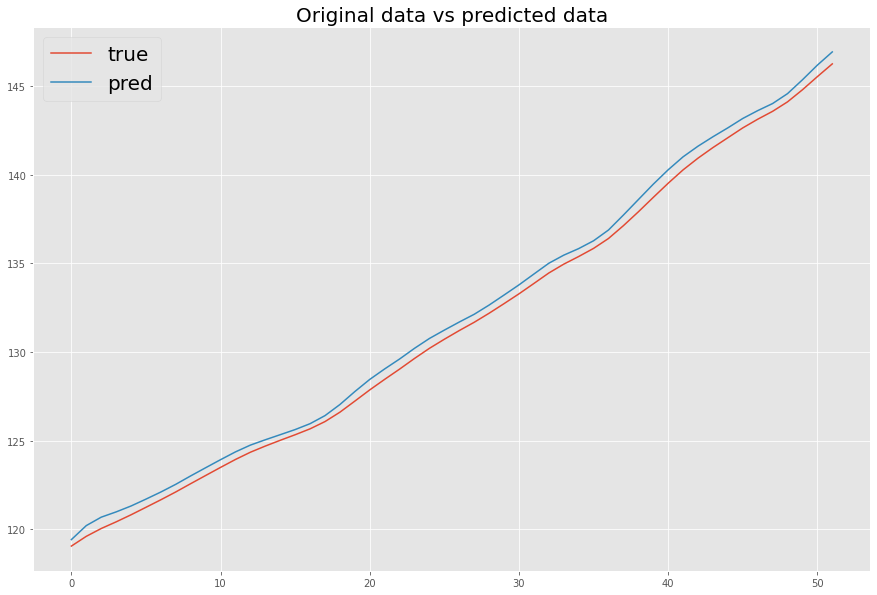

In [84]:
# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)], label='true')
plt.plot(predictions, label='pred')
plt.legend(fontsize=20)
plt.title('Original data vs predicted data', fontsize=20)
plt.show()

# Predict the house price for next years

In [85]:
# last value of our dataset
last_value = np.array([test_scaled[-1][0]])

In [86]:
last_value

array([0.53434187])

In [87]:
# initial record
initial = last_value
# store prediction
prediction = []
# set range to 40 for next 40 months prediction
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = invert_scale(scaler, initial, yhat)
    # invert differencing
    if i == 0:
        yhat_diff = yhat_inver + raw_values[-1]
    else:
        yhat_diff = yhat_inver + prediction[i-1] 
    # append to our prediction variable
    prediction.append(yhat_diff)
    # Re initial our initial variable 
    # to feed the current predicted value as input for forecast
    initial = np.array([yhat])

### Plot housing price prediction

In [88]:
prediction = pd.DataFrame(prediction)

In [89]:
rng = pd.date_range('2018-01-31 00:00:00', periods=40, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, 
                      left_index=True, right_index=True, how='outer')
prediction.columns = ['Date', 'ZHVIPerSqft_AllHomes']
prediction

Date  ZHVIPerSqft_AllHomes
0  2018-01-31            147.506994
1  2018-02-28            148.171330
2  2018-03-31            148.815423
3  2018-04-30            149.438794
4  2018-05-31            150.040839
..        ...                   ...
35 2020-12-31            157.328492
36 2021-01-31            157.108631
37 2021-02-28            156.845406
38 2021-03-31            156.537698
39 2021-04-30            156.185385

[40 rows x 2 columns]

In [90]:
original = pd.DataFrame({'Date':df_zhvi_sqft_all.index, 
                         'ZHVIPerSqft_AllHomes':df_zhvi_sqft_all.values})
middle = original.shape[0]
original

Date  ZHVIPerSqft_AllHomes
0   1996-04-30             72.056369
1   1996-05-31             72.021660
2   1996-06-30             71.979891
3   1996-07-31             71.976152
4   1996-08-31             71.964629
..         ...                   ...
256 2017-08-31            144.095938
257 2017-09-30            144.777011
258 2017-10-31            145.517059
259 2017-11-30            146.236881
260 2017-12-31            146.824695

[261 rows x 2 columns]

In [91]:
frames = [original, prediction]
df_final = pd.concat(frames)
df_final.set_index(['Date'],inplace=True)

In [92]:
df_final = pd.Series(df_final.ZHVIPerSqft_AllHomes)

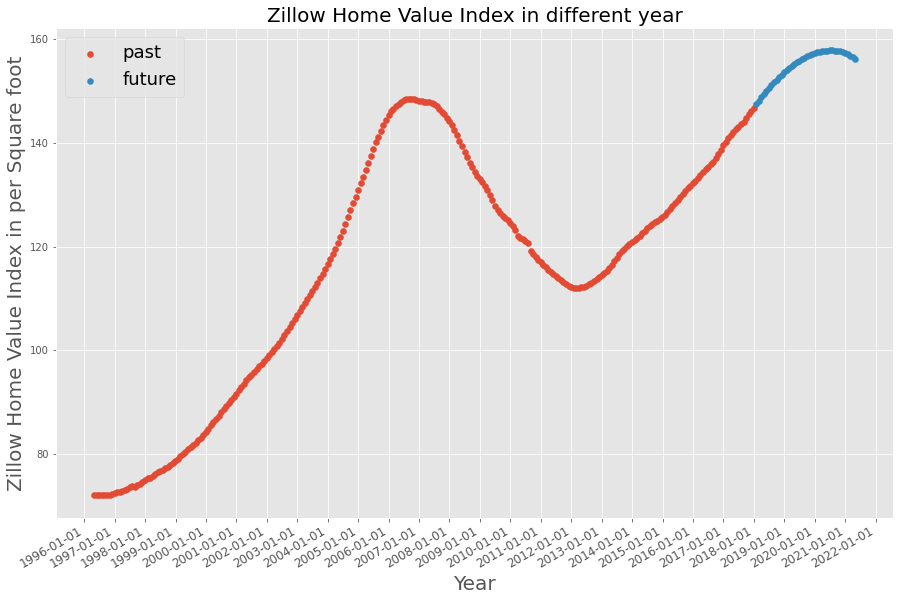

In [93]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(df_final.index[:middle], df_final[:middle], label='past')
ax.scatter(df_final.index[middle:], df_final[middle:], label='future')
ax.xaxis.set_major_locator(mdates.YearLocator(1))

plt.title('Zillow Home Value Index in different year', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Zillow Home Value Index in per Square foot', fontsize=20)
ax.legend(fontsize=18, loc='upper left') # legend position
fig.autofmt_xdate()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

# Save the figure
plt.savefig('./forecast.pdf') 

